# Atul's Brooklyn housing price predictions

_September 20, 2017_

This is just some experimenting I did after taking the second week of Coursera's [Machine Learning](https://www.coursera.org/learn/machine-learning) class, which covers linear regression.

The example Andrew Ng uses to motivate linear regression is predicting housing prices in Portland, so I figured I would do the same thing, but with Brooklyn.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

I found the [NYC Department of Finance’s Rolling Sales data](http://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page), which was in excel format, and converted it to CSV. Here's what it looks like:

In [2]:
# Column name for square footage.
SQFT = 'GROSS SQUARE FEET'

# Column name for price.
PRICE = 'SALE PRICE'

# Maximum square footage that we care about.
MAX_SQFT = 4500

sa = pd.read_csv('rollingsales_brooklyn.csv')
for colname in [SQFT, PRICE]:
    sa[colname] = pd.to_numeric(sa[colname].str.replace(',', ''), errors='coerce')
    sa = sa[pd.notnull(sa[colname])]
sa = sa[sa[SQFT] < MAX_SQFT]

sa[:3]

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,3,BATH BEACH,01 ONE FAMILY DWELLINGS,1,6360,157,,A5,36 BAY 10TH STREET,,...,1,0,1,"1,547",1428.0,1930,1,A5,800000.0,2/27/17
3,3,BATH BEACH,01 ONE FAMILY DWELLINGS,1,6367,42,,S1,1730 86TH STREET,,...,1,1,2,"1,342",1920.0,1926,1,S1,1200000.0,3/31/17
4,3,BATH BEACH,01 ONE FAMILY DWELLINGS,1,6374,67,,S1,8642 20TH AVENUE,,...,1,1,2,"1,740",3240.0,1925,1,S1,1090000.0,10/24/16


I wanted to be able to easily drill down by neighborhood, so here's a list of all the available neighborhoods...

In [3]:
sa['NEIGHBORHOOD'].drop_duplicates().values

array(['BATH BEACH', 'BAY RIDGE', 'BEDFORD STUYVESANT', 'BENSONHURST',
       'BERGEN BEACH', 'BOERUM HILL', 'BOROUGH PARK', 'BRIGHTON BEACH',
       'BROOKLYN HEIGHTS', 'BROWNSVILLE', 'BUSH TERMINAL', 'BUSHWICK',
       'CANARSIE', 'CARROLL GARDENS', 'CLINTON HILL', 'COBBLE HILL',
       'COBBLE HILL-WEST', 'CONEY ISLAND', 'CROWN HEIGHTS',
       'CYPRESS HILLS', 'DOWNTOWN-FULTON FERRY', 'DOWNTOWN-FULTON MALL',
       'DOWNTOWN-METROTECH', 'DYKER HEIGHTS', 'EAST NEW YORK',
       'FLATBUSH-CENTRAL', 'FLATBUSH-EAST', 'FLATBUSH-LEFFERTS GARDEN',
       'FLATBUSH-NORTH', 'FLATLANDS', 'FORT GREENE', 'GERRITSEN BEACH',
       'GOWANUS', 'GRAVESEND', 'GREENPOINT', 'KENSINGTON', 'MADISON',
       'MANHATTAN BEACH', 'MARINE PARK', 'MIDWOOD', 'MILL BASIN',
       'NAVY YARD', 'OCEAN HILL', 'OCEAN PARKWAY-NORTH',
       'OCEAN PARKWAY-SOUTH', 'OLD MILL BASIN', 'PARK SLOPE',
       'PARK SLOPE SOUTH', 'PROSPECT HEIGHTS', 'RED HOOK', 'SEAGATE',
       'SHEEPSHEAD BAY', 'SPRING CREEK', 'SUNSET PAR

And here's a function that returns only the dataframe rows that correspond to a given neighborhood...

In [4]:
def hood(name):
    return sa[sa['NEIGHBORHOOD'] == name]

Now let's do some plotting!

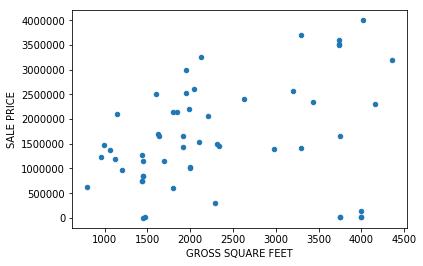

In [5]:
hood('GOWANUS').plot(x=SQFT, y=PRICE, kind='scatter')

Neato. Now let's create an _unvectorized_ cost function, given a dataframe and linear regression parameters.

In [6]:
def unvectorized_cost(df, theta_0, theta_1):
    X = df[SQFT].values
    Y = df[PRICE].values
    m = len(X)
    total = 0
    for i in range(m):
        total += np.power((theta_0 + theta_1 * X[i]) - Y[i], 2)
    return total / m / 2

unvectorized_cost(hood('GOWANUS'), 1, 2)

1880960580557.3147

Now let's make a vectorized version of the same function.

In [7]:
def cost(df, theta_0, theta_1):
    X = df[SQFT].values
    Y = df[PRICE].values
    m = len(X)
    predicted_Y = theta_0 + theta_1 * X
    total = np.sum(np.power(predicted_Y - Y, 2))
    return total / m / 2

# Make sure it produces the same output as our unvectorized version.
assert unvectorized_cost(hood('GOWANUS'), 1, 2) == cost(hood('GOWANUS'), 1, 2)

Now let's create an unvectorized gradient-following function. Obviously using an analytical solution would be more efficient here, given our features, but I want to make sure I understand the general concept of gradient descent.

In [8]:
def unvectorized_follow_gradient(df, theta_0, theta_1, learning_rate):
    X = df[SQFT].values
    Y = df[PRICE].values
    m = len(X)
    total_theta_0 = 0
    total_theta_1 = 0
    for i in range(m):
        predicted_y = theta_0 + theta_1 * X[i]
        total_theta_0 += (predicted_y - Y[i]) * 1
        total_theta_1 += (predicted_y - Y[i]) * X[i]
    d_theta_0 = total_theta_0 / m
    d_theta_1 = total_theta_1 / m
    return (theta_0 - learning_rate * d_theta_0,
            theta_1 - learning_rate * d_theta_1)


Cool, now let's use the function to fit a line to our data!

In [9]:
theta_0 = 0
theta_1 = 0
df = hood('GOWANUS')

for i in range(1000):
    if i % 100 == 0:
        print(f"cost at iteration {i} when theta_0={theta_0}, theta_1={theta_1} is {cost(df, theta_0, theta_1)}")
    theta_0, theta_1 = unvectorized_follow_gradient(df, theta_0, theta_1, learning_rate=0.000000001)


cost at iteration 0 when theta_0=0, theta_1=0 is 1889128504421.8518
cost at iteration 100 when theta_0=0.1242402438821919, theta_1=301.55127916828667 is 950955905027.8193
cost at iteration 200 when theta_0=0.19664449825627317, theta_1=458.80443353537134 is 695827305949.8993
cost at iteration 300 when theta_0=0.2420172869986939, theta_1=540.8089079712018 is 626447105154.222
cost at iteration 400 when theta_0=0.27329368934626047, theta_1=583.5726518764226 is 607579707997.0375
cost at iteration 500 when theta_0=0.2972190988286313, theta_1=605.8731141136767 is 602448867144.0631
cost at iteration 600 when theta_0=0.31731110764891257, theta_1=617.5023709232973 is 601053573825.7135
cost at iteration 700 when theta_0=0.3354040720760091, theta_1=623.5668005890388 is 600674133030.6895
cost at iteration 800 when theta_0=0.3524545734095658, theta_1=626.7292805780296 is 600570945272.0901
cost at iteration 900 when theta_0=0.3689614502876063, theta_1=628.3784499629963 is 600542882335.6292


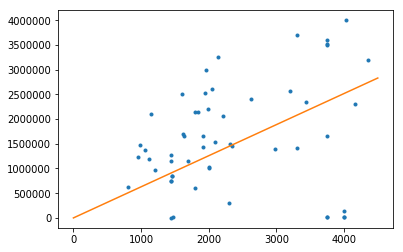

In [10]:
square_footage = np.arange(0, MAX_SQFT)
predicted_prices = theta_0 + theta_1 * square_footage

plt.plot(df[SQFT], df[PRICE], '.')
plt.plot(square_footage, predicted_prices, '-')